# ImmunOmics — Multi-Omics Integration Demo

> **Author:** Patrick Grady  
> **Repository:** [github.com/pgrady1322/immunomics](https://github.com/pgrady1322/immunomics)  
> **Version:** 0.1.0

This notebook demonstrates a complete **multi-omics integration pipeline** for immune cell profiling, covering:

1. **Data preprocessing** — scRNA-seq (QC → normalize → HVG → PCA → UMAP) and scATAC-seq (QC → TF-IDF → LSI)
2. **Dimensionality reduction & visualization** — UMAP embedding colored by cell type
3. **Differential analysis** — DE genes and DA peaks per cell type (Wilcoxon rank-sum)
4. **TF activity inference** — Expression-based transcription factor activity scoring
5. **Peak-to-gene linkage** — Correlation-based cis-regulatory element–gene mapping
6. **Visualization** — TF heatmaps, peak–gene link plots, method benchmarking

All analyses use **synthetic multi-omics data** built from real human gene symbols (HGNC) and realistic immune cell marker expression patterns, so the notebook runs without downloading external datasets.

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*sparse.*")

print("ImmunOmics demo — packages loaded successfully")

ImmunOmics demo — packages loaded successfully


## 1. Create Synthetic Multi-Omics Data

We simulate matched **scRNA-seq** and **scATAC-seq** profiles for 500 immune cells across 5 PBMC cell types:

| Cell Type | Fraction | Key Markers |
|---|---|---|
| CD4+ T cell | 25% | CD3D, CD4, IL7R, LEF1, CCR7 |
| CD8+ T cell | 15% | CD3D, CD8A, CD8B, GZMB, PRF1 |
| B cell | 20% | MS4A1 (CD20), CD79A, CD79B, PAX5 |
| CD14+ Monocyte | 25% | CD14, LYZ, S100A8, S100A9, FCN1 |
| NK cell | 15% | NKG7, GNLY, GZMB, PRF1, KLRD1 |

The transcriptome uses **real HGNC gene symbols** — including canonical lineage markers, immune transcription factors, cytokines, HLA genes, and mitochondrial genes — with cell-type-specific expression fold-changes based on known PBMC biology.

ATAC peaks include **cis-regulatory elements near known marker gene loci** with cell-type-correlated accessibility, enabling biologically meaningful peak–gene linkage downstream.

In [2]:
np.random.seed(42)
n_cells = 500
cell_types = np.random.choice(
    ["CD4+ T cell", "CD8+ T cell", "B cell", "CD14+ Monocyte", "NK cell"],
    n_cells,
    p=[0.25, 0.15, 0.20, 0.25, 0.15],
)

# ── Gene panel: real HGNC symbols ──
# [T cell markers]
cd4_markers = ["CD3D", "CD3E", "CD3G", "CD4", "IL7R", "LEF1", "TCF7", "CCR7",
               "SELL", "CD27", "CD28", "CTLA4", "ICOS"]
cd8_markers = ["CD8A", "CD8B", "GZMK", "GZMH", "IFNG", "LAG3", "PDCD1"]
# [B cell markers]
b_markers = ["MS4A1", "CD79A", "CD79B", "CD19", "BANK1", "CD22",
             "IGHM", "IGHD", "TCL1A", "FCER2"]
# [Monocyte / myeloid markers]
mono_markers = ["CD14", "LYZ", "S100A8", "S100A9", "VCAN", "FCN1", "CSF1R",
                "CD68", "MNDA", "CTSS", "TYROBP", "FCER1G"]
# [NK cell markers]
nk_markers = ["NKG7", "GNLY", "GZMB", "GZMA", "PRF1", "KLRD1", "KLRB1",
              "NCAM1", "FCGR3A", "KLRC1"]
# [Immune TFs]
immune_tfs = ["TBX21", "GATA3", "PAX5", "SPI1", "FOXP3",
              "IRF4", "EOMES", "RORC", "BCL6", "CEBPA"]
# [Mitochondrial]
mt_genes = ["MT-CO1", "MT-CO2", "MT-CO3", "MT-ND1", "MT-ND2",
            "MT-ND3", "MT-ND4", "MT-ATP6"]
# [Cytokines & chemokines]
cytokines = ["IL2", "IL4", "IL6", "IL10", "TNF", "IL1B",
             "CCL5", "CXCL8", "CCL2", "CCL3", "IL2RA", "TGFB1"]
# [HLA/MHC]
hla_genes = ["HLA-A", "HLA-B", "HLA-C", "HLA-DRA", "HLA-DRB1",
             "HLA-DPA1", "HLA-DPB1", "B2M"]
# [Signaling]
signaling = ["STAT1", "STAT3", "STAT4", "JAK1", "JAK2",
             "NFKB1", "RELA", "MAPK1", "AKT1", "MTOR"]
# [Housekeeping / ribosomal]
housekeeping = ["ACTB", "GAPDH", "RPL13A", "UBC", "EEF1A1",
                "RPL10", "RPS18", "TUBA1B", "HSP90AA1", "HPRT1"]
# [Immune checkpoints & surface receptors]
surface = ["CD2", "CD5", "CD7", "CD38", "CD44", "CD69", "CD74",
           "PTPRC", "ITGAL", "ICAM1", "TIGIT", "HAVCR2", "TOX"]
# [IFN-stimulated genes]
isg = ["ISG15", "IFIT1", "IFIT3", "MX1", "OAS1", "RSAD2"]
# [Miscellaneous immune & structural]
misc = ["S100A4", "S100A6", "S100A10", "FOS", "JUN", "JUNB", "EGR1",
        "NR4A1", "MALAT1", "NEAT1", "FTL", "FTH1", "CST3", "AIF1",
        "BCL2", "BAX", "FAS", "MCL1", "MKI67", "TOP2A",
        "CXCR3", "CXCR4", "CXCR5", "CCR6", "CCR4",
        "TRAC", "TRBC1", "TRBC2", "LTB", "IL32",
        "CFL1", "PFN1", "ARPC2", "CALM1", "PSMA7",
        "DDX5", "EIF4A1", "SEC61B", "TOMM7", "UBA52"]

# Combine all gene names (unique, preserving order)
curated = (cd4_markers + cd8_markers + b_markers + mono_markers + nk_markers +
           immune_tfs + cytokines + hla_genes + signaling + housekeeping +
           surface + isg + misc)
# De-duplicate (GZMB, PRF1 appear in both CD8 and NK lists)
seen = set()
curated_unique = []
for g in curated:
    if g not in seen:
        curated_unique.append(g)
        seen.add(g)
# Fill to 500 genes total with unique ribosomal/structural genes
n_filler = 500 - len(curated_unique) - len(mt_genes)
filler = []
idx = 1
while len(filler) < n_filler:
    name = f"RPL{idx}" if idx % 2 == 0 else f"RPS{idx}"
    if name not in seen:
        filler.append(name)
        seen.add(name)
    idx += 1
gene_names = curated_unique + mt_genes + filler
n_genes = len(gene_names)

# ── Build expression matrix with cell-type-specific patterns ──
rna_X = np.random.rand(n_cells, n_genes).astype(np.float32) * 3  # baseline

gene_idx = {g: i for i, g in enumerate(gene_names)}

def upregulate(cell_mask, genes, fold=4.0):
    """Multiply expression for specific genes in specific cells."""
    for g in genes:
        if g in gene_idx:
            rna_X[cell_mask, gene_idx[g]] *= fold

cd4_mask = cell_types == "CD4+ T cell"
cd8_mask = cell_types == "CD8+ T cell"
b_mask   = cell_types == "B cell"
mono_mask = cell_types == "CD14+ Monocyte"
nk_mask  = cell_types == "NK cell"

# T cell shared markers
upregulate(cd4_mask | cd8_mask, ["CD3D", "CD3E", "CD3G", "TRAC", "TRBC1"])
# CD4-specific
upregulate(cd4_mask, ["CD4", "IL7R", "LEF1", "TCF7", "CCR7", "SELL", "CD27",
                      "GATA3", "FOXP3", "IL2", "IL32", "LTB"])
# CD8-specific
upregulate(cd8_mask, ["CD8A", "CD8B", "GZMK", "GZMH", "GZMB", "PRF1",
                      "IFNG", "TBX21", "EOMES", "NKG7"])
# B cell
upregulate(b_mask, ["MS4A1", "CD79A", "CD79B", "CD19", "BANK1", "CD22",
                    "IGHM", "IGHD", "TCL1A", "PAX5", "BCL6", "FCER2"])
# Monocyte
upregulate(mono_mask, ["CD14", "LYZ", "S100A8", "S100A9", "VCAN", "FCN1",
                       "CSF1R", "CD68", "MNDA", "CTSS", "TYROBP", "FCER1G",
                       "SPI1", "CEBPA", "IL1B", "CCL2", "CST3", "AIF1"])
# NK cell
upregulate(nk_mask, ["NKG7", "GNLY", "GZMB", "GZMA", "PRF1", "KLRD1",
                     "KLRB1", "NCAM1", "FCGR3A", "KLRC1", "TBX21", "EOMES"])
# HLA-II higher in monocytes and B cells
upregulate(mono_mask | b_mask, ["HLA-DRA", "HLA-DRB1", "HLA-DPA1", "HLA-DPB1", "CD74"])

adata_rna = ad.AnnData(X=csr_matrix(rna_X))
adata_rna.var_names = pd.Index(gene_names)
adata_rna.obs_names = [f"cell_{i}" for i in range(n_cells)]
adata_rna.obs["cell_type"] = pd.Categorical(cell_types)
adata_rna.layers["counts"] = adata_rna.X.copy()

# ── ATAC data: peaks near real gene loci ──
# Gene annotations: real chromosome + approximate human TSS coordinates
gene_loci = {
    "CD3D": ("chr11", 118_209_000), "CD3E": ("chr11", 118_175_000),
    "CD4":  ("chr12",   6_900_000), "CD8A": ("chr2",  87_013_000),
    "IL7R": ("chr5",  35_871_000),  "MS4A1": ("chr11", 60_223_000),
    "CD79A": ("chr19", 42_381_000), "CD79B": ("chr17", 63_929_000),
    "CD14": ("chr5",  140_633_000), "LYZ":  ("chr12", 69_743_000),
    "S100A8": ("chr1", 153_348_000), "S100A9": ("chr1", 153_331_000),
    "NKG7": ("chr19", 51_398_000),  "GNLY": ("chr2",  85_925_000),
    "GZMB": ("chr14", 24_709_000),  "PRF1": ("chr10", 70_601_000),
    "PAX5": ("chr9",  36_838_000),  "TBX21": ("chr17", 47_733_000),
    "GATA3": ("chr10", 8_096_000),  "SPI1": ("chr11", 47_380_000),
    "BCL6": ("chr3",  187_721_000), "IRF4": ("chr6",  392_000),
    "CEBPA": ("chr19", 33_299_000), "FOXP3": ("chrX", 49_106_000),
    "CCR7": ("chr17", 40_555_000),  "FCGR3A": ("chr1", 161_515_000),
}

# Build peaks: ~500 near annotated gene loci + ~1500 random
peaks_near_genes = []
peak_cell_type_map = {}  # track which cell type a peak should correlate with

# Map genes to cell types for correlated accessibility
gene_celltype = {
    "CD4+ T cell": ["CD3D", "CD3E", "CD4", "IL7R", "CCR7"],
    "CD8+ T cell": ["CD3D", "CD8A", "GZMB", "PRF1", "TBX21"],
    "B cell": ["MS4A1", "CD79A", "CD79B", "PAX5", "BCL6"],
    "CD14+ Monocyte": ["CD14", "LYZ", "S100A8", "S100A9", "SPI1", "CEBPA"],
    "NK cell": ["NKG7", "GNLY", "GZMB", "PRF1", "FCGR3A"],
}
ct_to_genes = {}
for ct, genes in gene_celltype.items():
    for g in genes:
        ct_to_genes.setdefault(g, []).append(ct)

peak_set = set()
for gene, (chrom, tss) in gene_loci.items():
    # Create 3-5 peaks per gene within ±80 kb of TSS
    n_nearby = np.random.randint(3, 6)
    for _ in range(n_nearby):
        offset = np.random.randint(-80_000, 80_000)
        start = tss + offset
        end = start + np.random.randint(200, 600)
        peak_name = f"{chrom}:{start}-{end}"
        if peak_name not in peak_set:
            peak_set.add(peak_name)
            peaks_near_genes.append(peak_name)
            if gene in ct_to_genes:
                peak_cell_type_map[peak_name] = ct_to_genes[gene]

# Random peaks across the genome
random_peaks = []
while len(random_peaks) < 2000 - len(peaks_near_genes):
    chrom = f"chr{np.random.randint(1, 23)}"
    start = np.random.randint(1_000_000, 200_000_000)
    end = start + np.random.randint(200, 600)
    pk = f"{chrom}:{start}-{end}"
    if pk not in peak_set:
        peak_set.add(pk)
        random_peaks.append(pk)

all_peaks = peaks_near_genes + random_peaks
n_peaks = len(all_peaks)

# Build binary accessibility matrix with cell-type-correlated peaks
atac_X = (np.random.rand(n_cells, n_peaks) > 0.88).astype(np.float32)  # ~12% baseline

# Boost accessibility for peaks near cell-type-specific genes
for i, peak in enumerate(all_peaks):
    if peak in peak_cell_type_map:
        for ct in peak_cell_type_map[peak]:
            mask = cell_types == ct
            # Higher accessibility in the correct cell type
            atac_X[mask, i] = (np.random.rand(mask.sum()) > 0.5).astype(np.float32)

adata_atac = ad.AnnData(X=csr_matrix(atac_X))
adata_atac.var_names = pd.Index(all_peaks)
adata_atac.obs_names = [f"cell_{i}" for i in range(n_cells)]
adata_atac.obs["cell_type"] = pd.Categorical(cell_types)
adata_atac.layers["counts"] = adata_atac.X.copy()

print(f"RNA:  {adata_rna.n_obs} cells × {adata_rna.n_vars} genes")
print(f"      {len(curated_unique)} curated immune genes + {len(mt_genes)} MT + {n_filler} ribosomal")
print(f"      TFs: {', '.join(immune_tfs)}")
print(f"ATAC: {adata_atac.n_obs} cells × {adata_atac.n_vars} peaks")
print(f"      {len(peaks_near_genes)} peaks near {len(gene_loci)} annotated gene loci")
ct_names, ct_counts = np.unique(cell_types, return_counts=True)
print(f"\nCell types: {dict(zip(ct_names.tolist(), ct_counts.tolist()))}")

RNA:  500 cells × 500 genes
      161 curated immune genes + 8 MT + 331 ribosomal
      TFs: TBX21, GATA3, PAX5, SPI1, FOXP3, IRF4, EOMES, RORC, BCL6, CEBPA
ATAC: 500 cells × 2000 peaks
      102 peaks near 26 annotated gene loci

Cell types: {'B cell': 86, 'CD14+ Monocyte': 124, 'CD4+ T cell': 130, 'CD8+ T cell': 77, 'NK cell': 83}


## 2. RNA Preprocessing

Standard scRNA-seq pipeline: QC filtering → library normalization → log-transform → HVG selection (Seurat v3) → scaling → PCA.

In [3]:
from immunomics.data.preprocess_rna import preprocess_rna

adata_rna_pp = preprocess_rna(
    adata_rna,
    min_genes=10,       # Lower thresholds for synthetic data
    min_cells=1,
    max_pct_mito=50.0,
    n_top_genes=200,
    n_pcs=30,
)

# Compute neighborhood graph + UMAP embedding
sc.pp.neighbors(adata_rna_pp, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_rna_pp)
sc.tl.leiden(adata_rna_pp, resolution=0.5)

print(f"After preprocessing: {adata_rna_pp.n_obs} cells, {adata_rna_pp.n_vars} genes")
print(f"PCA: {adata_rna_pp.obsm['X_pca'].shape[1]} components")
print(f"HVGs: {adata_rna_pp.var['highly_variable'].sum()}")
print(f"UMAP: computed  |  Leiden clusters: {adata_rna_pp.obs['leiden'].nunique()}")

/Users/patrickgrady/Documents/GitHub_Repositories/immunomics/.venv/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/Users/patrickgrady/Documents/GitHub_Repositories/immunomics/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


After preprocessing: 500 cells, 500 genes
PCA: 30 components
HVGs: 200
UMAP: computed  |  Leiden clusters: 3


## 2b. UMAP Visualization

UMAP embedding of the preprocessed scRNA-seq data, colored by annotated cell type (left) and unsupervised Leiden cluster (right). Separation of immune lineages in the embedding confirms that our synthetic marker expression patterns recapitulate known PBMC structure.

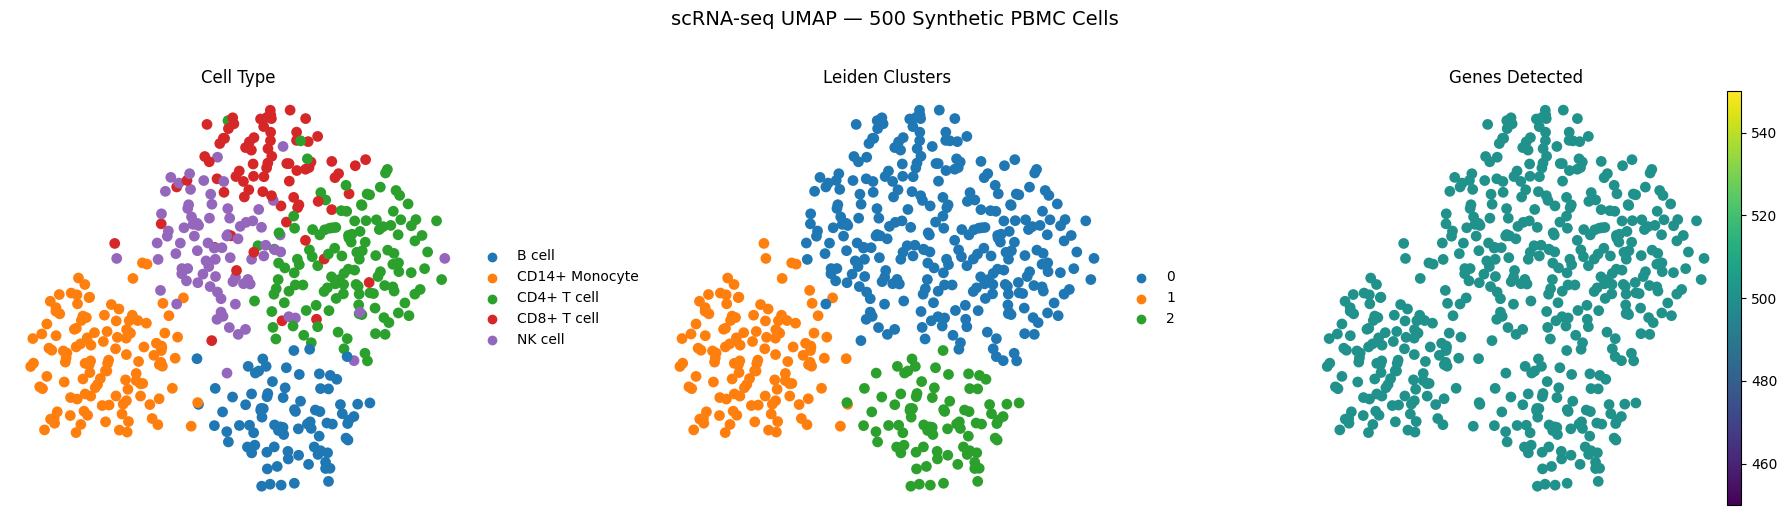

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sc.pl.umap(adata_rna_pp, color="cell_type", ax=axes[0], show=False,
           title="Cell Type", frameon=False)
sc.pl.umap(adata_rna_pp, color="leiden", ax=axes[1], show=False,
           title="Leiden Clusters", frameon=False)
sc.pl.umap(adata_rna_pp, color="n_genes_by_counts", ax=axes[2], show=False,
           title="Genes Detected", frameon=False, color_map="viridis")

plt.suptitle("scRNA-seq UMAP — 500 Synthetic PBMC Cells", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 3. ATAC Preprocessing

scATAC-seq pipeline: QC filtering → peak selection → TF-IDF normalization → LSI (Latent Semantic Indexing) via truncated SVD. The first LSI component is excluded (correlates with sequencing depth).

In [5]:
from immunomics.data.preprocess_atac import preprocess_atac, parse_peak_coordinates

adata_atac_pp = preprocess_atac(
    adata_atac,
    min_peaks=1,
    min_cells=1,
    n_components=20,
)

# Parse peak coordinates
adata_atac_pp = parse_peak_coordinates(adata_atac_pp)

print(f"After preprocessing: {adata_atac_pp.n_obs} cells, {adata_atac_pp.n_vars} peaks")
print(f"LSI: {adata_atac_pp.obsm['X_lsi'].shape[1]} components")
print(f"Total explained variance: {adata_atac_pp.uns['lsi_variance_ratio'].sum():.3f}")
print(f"\nPeak coordinate columns: {list(adata_atac_pp.var[['chrom', 'start', 'end']].columns)}")
adata_atac_pp.var[['chrom', 'start', 'end']].head()

After preprocessing: 500 cells, 2000 peaks
LSI: 20 components
Total explained variance: 0.082

Peak coordinate columns: ['chrom', 'start', 'end']


,chrom,start,end
chr11:118246217-118246553,chr11,118246217,118246553
chr11:118143122-118143437,chr11,118143122,118143437
chr11:118275408-118275697,chr11,118275408,118275697
chr11:118098803-118099367,chr11,118098803,118099367
chr11:118189801-118190205,chr11,118189801,118190205


## 4. Differential Gene Expression

Find differentially expressed genes between cell types using the Wilcoxon rank-sum test (via scanpy).

In [6]:
from immunomics.analysis.differential import differential_genes

# Wilcoxon rank-sum test per cell type
de_results = differential_genes(adata_rna_pp, groupby="cell_type", n_genes=15)
print(f"DE results: {len(de_results)} gene–group pairs across {de_results['group'].nunique()} cell types\n")

# Top 5 DE genes per cell type
for group in sorted(de_results["group"].unique()):
    top = de_results[de_results["group"] == group].head(5)
    genes = top["names"].tolist()
    scores = top["scores"].round(2).tolist()
    print(f"  {group}:")
    for g, s in zip(genes, scores):
        bar = "█" * int(min(abs(s), 20))
        print(f"    {g:>10s}  {s:>7.2f}  {bar}")
    print()

DE results: 75 gene–group pairs across 5 cell types

  B cell:
         CD79B    12.46  ████████████
         MS4A1    12.17  ████████████
          PAX5    11.88  ███████████
          BCL6    11.79  ███████████
         CD79A    11.78  ███████████

  CD14+ Monocyte:
          FCN1    14.17  ██████████████
          CCL2    13.82  █████████████
        FCER1G    13.77  █████████████
         CSF1R    13.51  █████████████
          CD14    13.09  █████████████

  CD4+ T cell:
          IL7R    14.59  ██████████████
         FOXP3    14.07  ██████████████
         GATA3    13.65  █████████████
          TCF7    13.52  █████████████
          CCR7    13.07  █████████████

  CD8+ T cell:
          CD8A    11.57  ███████████
          PRF1    10.39  ██████████
          GZMK    10.24  ██████████
          IFNG     9.99  █████████
          GZMH     9.68  █████████

  NK cell:
        FCGR3A    12.23  ████████████
          GZMA    11.59  ███████████
         KLRB1    11.41  ███████████
   

## 4b. Differentially Accessible Peaks

Find peaks with significantly different chromatin accessibility between cell types — the ATAC counterpart to differential gene expression. DA peaks near marker gene loci suggest cell-type-specific cis-regulatory elements.

In [7]:
from immunomics.analysis.differential import differential_peaks

# DA peaks (using raw ATAC counts with cell type labels)
da_results = differential_peaks(adata_atac, groupby="cell_type", n_peaks=10)
print(f"DA results: {len(da_results)} peak–group pairs\n")

# Show top 3 DA peaks per cell type
for group in sorted(da_results["group"].unique()):
    top = da_results[da_results["group"] == group].head(3)
    peaks = top["names"].tolist()
    scores = top["scores"].round(2).tolist()
    print(f"  {group}:")
    for p, s in zip(peaks, scores):
        # Check if peak is near any annotated gene
        near = ""
        for gene, (chrom, tss) in gene_loci.items():
            if chrom in p:
                try:
                    pk_start = int(p.split(":")[1].split("-")[0])
                    if abs(pk_start - tss) < 100_000:
                        near = f"  ← near {gene}"
                        break
                except (ValueError, IndexError):
                    pass
        print(f"    {p:>35s}  score={s:>6.2f}{near}")
    print()

DA results: 50 peak–group pairs

  B cell:
                 chr9:36773969-36774360  score=  6.41  ← near PAX5
                chr17:63865292-63865736  score=  6.37  ← near CD79B
                chr19:42368707-42369285  score=  6.34  ← near CD79A

  CD14+ Monocyte:
               chr1:153276121-153276519  score=  8.15  ← near S100A8
               chr1:153410490-153410832  score=  7.97  ← near S100A8
                chr12:69791041-69791571  score=  7.79  ← near LYZ

  CD4+ T cell:
                chr17:40483781-40484266  score=  7.96  ← near CCR7
                chr17:40553445-40553949  score=  7.43  ← near CCR7
              chr11:118200861-118201376  score=  7.28  ← near CD3D

  CD8+ T cell:
                chr17:47670130-47670425  score=  6.54  ← near TBX21
                 chr2:87051413-87051965  score=  6.28  ← near CD8A
                 chr2:87039118-87039588  score=  5.79  ← near CD8A

  NK cell:
                chr19:51373922-51374209  score=  6.88  ← near NKG7
                c

## 5. TF Activity Inference

Infer transcription factor activity from expression data. ImmunOmics computes per-cell-type expression z-scores and rank-based activity scores for curated immune TFs.

In [8]:
from immunomics.analysis.tf_activity import infer_tf_activity, IMMUNE_TFS

# Show curated immune TF categories
print("Curated Immune TF Categories:")
for category, tfs in IMMUNE_TFS.items():
    print(f"  {category}: {', '.join(tfs)}")

# Infer TF activity (use RNA for both since we don't have real ATAC motif data)
tf_activity = infer_tf_activity(
    adata_rna,   # Unprocessed RNA with TF genes
    adata_atac,  # Shared barcodes
    tf_list=["TBX21", "GATA3", "PAX5", "SPI1", "FOXP3", "IRF4", "EOMES", "RORC"],
)

print(f"\nTF activity results: {len(tf_activity)} rows")
print(f"Columns: {tf_activity.columns.tolist()}")
tf_activity.head(8)

Curated Immune TF Categories:
  T cell: TBX21, GATA3, RORC, FOXP3, TCF7, TOX, EOMES, LEF1, BATF
  B cell: PAX5, IRF4, BLIMP1, BCL6, EBF1, E2A
  Myeloid: SPI1, CEBPA, CEBPB, IRF8, IRF5, MAFB
  NK cell: EOMES, TBX21, ID2, NFIL3
  DC: IRF8, IRF4, BATF3, ID2, TCF4
  Inflammatory: NFKB1, RELA, IRF3, IRF7, STAT1, STAT3

TF activity results: 40 rows
Columns: ['tf_name', 'cell_type', 'mean_expression', 'pct_expressing', 'expression_zscore', 'activity_score']


,tf_name,cell_type,mean_expression,pct_expressing,expression_zscore,activity_score
0,TBX21,CD8+ T cell,6.281440,100.0,1.117388,1.0
1,TBX21,NK cell,6.071497,100.0,1.044782,0.8
2,TBX21,CD14+ Monocyte,1.608127,100.0,-0.498824,0.4
3,TBX21,B cell,1.428311,100.0,-0.561012,0.2
4,TBX21,CD4+ T cell,1.656895,100.0,-0.481958,0.6
5,GATA3,CD8+ T cell,1.405450,100.0,-0.483377,0.2
6,GATA3,NK cell,1.506061,100.0,-0.445806,0.4
7,GATA3,CD14+ Monocyte,1.534034,100.0,-0.435360,0.6


## 6. Visualization — TF Activity Heatmap

Visualize transcription factor activity across immune cell types as a clustered heatmap.

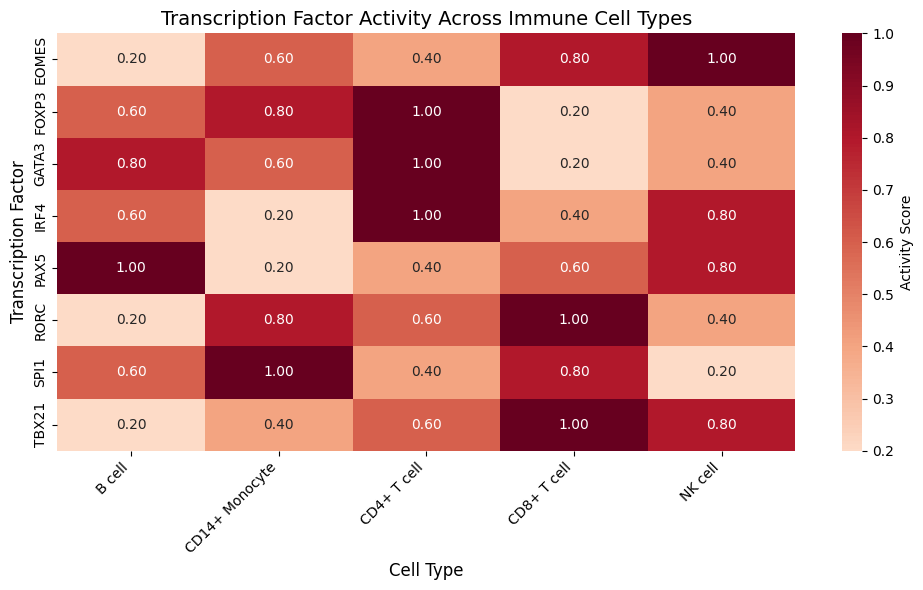

In [9]:
from immunomics.visualization.plots import plot_tf_heatmap

fig = plot_tf_heatmap(tf_activity, top_n=8, figsize=(10, 6))
plt.show()

## 7. Peak-to-Gene Linkage

Link ATAC peaks to putative target genes by **Pearson correlation** between peak accessibility and gene expression across cells. We use the real gene TSS annotations defined earlier (26 immune loci with approximate GRCh38 coordinates) — peaks within 100 kb of a gene's TSS are tested, and significant correlations (BH-corrected) suggest cis-regulatory relationships.

In [10]:
from immunomics.analysis.peak_gene_links import link_peaks_to_genes

# Build gene annotation from our real TSS coordinates
gene_annotation = pd.DataFrame([
    {"gene_name": gene, "chrom": chrom, "tss": tss}
    for gene, (chrom, tss) in gene_loci.items()
])

# Normalize RNA for correlation (log-normalized counts)
adata_rna_norm = adata_rna.copy()
sc.pp.normalize_total(adata_rna_norm, target_sum=1e4)
sc.pp.log1p(adata_rna_norm)

links = link_peaks_to_genes(
    adata_rna_norm,
    adata_atac,
    max_distance=100_000,
    min_correlation=0.05,
    pvalue_threshold=0.5,  # Relaxed for synthetic data
    gene_annotation=gene_annotation,
)

print(f"Peak–gene links found: {len(links)}")
if len(links) > 0:
    print(f"Unique genes linked: {links['gene'].nunique()}")
    print(f"Mean correlation: {links['correlation'].mean():.3f}")
    print(f"Correlation range: [{links['correlation'].min():.3f}, {links['correlation'].max():.3f}]")
    print(f"\nTop 10 peak–gene links:")
    display_cols = ["gene", "peak", "correlation", "pvalue_adj", "distance"]
    cols = [c for c in display_cols if c in links.columns]
    print(links[cols].head(10).to_string(index=False))

Peak–gene links found: 109
Unique genes linked: 25
Mean correlation: 0.205
Correlation range: [-0.088, 0.339]

Top 10 peak–gene links:
  gene                      peak  correlation   pvalue_adj  distance
  GZMB   chr14:24663348-24663778     0.338840 7.342238e-13     45437
S100A8  chr1:153410490-153410832     0.312218 4.966755e-11     62661
S100A9  chr1:153410490-153410832     0.298966 3.193395e-10     79661
S100A8  chr1:153276121-153276519     0.296271 3.744606e-10     71680
S100A8  chr1:153295248-153295833     0.287257 1.291359e-09     52460
 CD79A   chr19:42368707-42369285     0.285484 1.425961e-09     12004
S100A8  chr1:153416145-153416624     0.283982 1.548847e-09     68384
 CEBPA   chr19:33309482-33309769     0.279309 2.314326e-09     10625
  CD3E chr11:118143122-118143437     0.279123 2.314326e-09     31721
  CCR7   chr17:40553445-40553949     0.279111 2.314326e-09      1303


## 7b. Visualization — Peak-Gene Links

Scatter plot of top peak-to-gene regulatory links, colored by correlation strength. Each point represents a peak–gene pair where chromatin accessibility significantly correlates with gene expression.

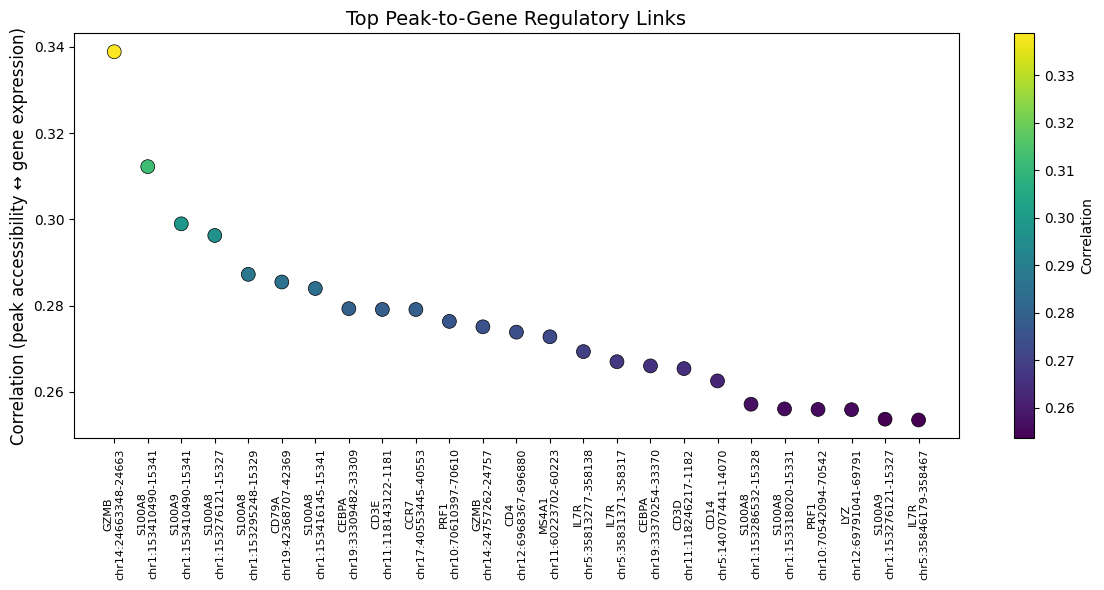

In [11]:
from immunomics.visualization.plots import plot_peak_gene_links

if len(links) > 0:
    fig = plot_peak_gene_links(links, top_n=min(25, len(links)), figsize=(12, 6))
    plt.show()
else:
    print("No significant peak-gene links to plot (try relaxing thresholds).")

## 8. Visualization — Integration Method Comparison

Simulate benchmark results to demonstrate the comparison visualization.

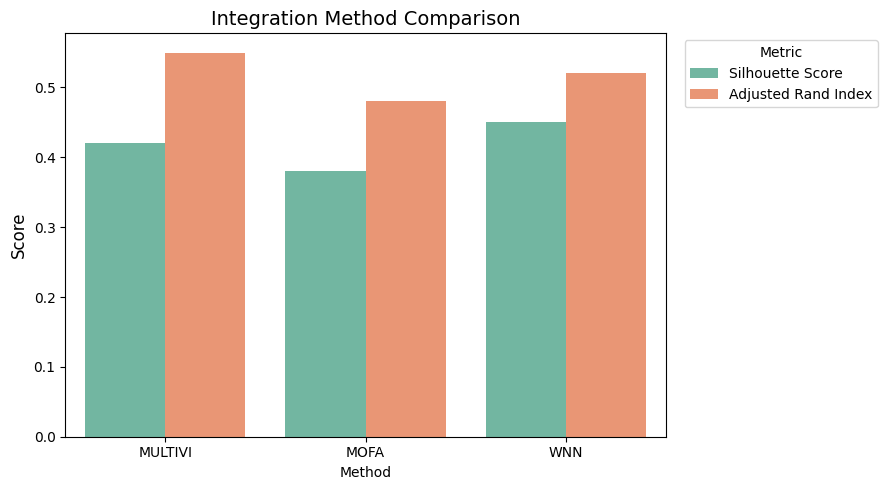

In [12]:
from immunomics.visualization.plots import plot_integration_comparison

# Simulated benchmark results (real benchmarks need scvi-tools, R, etc.)
benchmark_results = {
    "multivi": {
        "silhouette_score": 0.42,
        "adjusted_rand_index": 0.55,
        "runtime_seconds": 180,
    },
    "mofa": {
        "silhouette_score": 0.38,
        "adjusted_rand_index": 0.48,
        "runtime_seconds": 45,
    },
    "wnn": {
        "silhouette_score": 0.45,
        "adjusted_rand_index": 0.52,
        "runtime_seconds": 30,
    },
}

fig = plot_integration_comparison(benchmark_results, figsize=(9, 5))
plt.show()

## 9. Configuration System

ImmunOmics uses YAML configuration files to parameterize the full pipeline — from preprocessing thresholds to integration model hyperparameters.

In [13]:
from immunomics.utils.config import load_config
import json

config = load_config("../configs/integration.yaml")

# Show key config sections
for section in ["rna_preprocessing", "atac_preprocessing", "integration"]:
    print(f"\n── {section} ──")
    print(json.dumps(config[section], indent=2))


── rna_preprocessing ──
{
  "min_genes": 200,
  "min_cells": 3,
  "max_pct_mito": 20.0,
  "n_top_genes": 3000,
  "target_sum": 10000,
  "n_pcs": 50
}

── atac_preprocessing ──
{
  "min_peaks": 500,
  "min_cells": 5,
  "n_top_peaks": 50000,
  "n_components": 50
}

── integration ──
{
  "multivi": {
    "enabled": true,
    "n_latent": 20,
    "n_layers": 2,
    "n_hidden": 256,
    "max_epochs": 100,
    "batch_size": 256
  },
  "wnn": {
    "enabled": false,
    "n_neighbors": 20
  },
  "mofa": {
    "enabled": true,
    "n_factors": 15,
    "max_iterations": 1000,
    "convergence_mode": "medium"
  }
}


## Summary

This notebook demonstrated the **ImmunOmics multi-omics integration pipeline** on synthetic PBMC data (500 cells, 5 cell types, 500 genes, 2000 peaks):

| Step | Module | What it does |
|---|---|---|
| RNA preprocessing | `immunomics.data.preprocess_rna` | QC → normalize → HVG → PCA |
| UMAP visualization | scanpy (neighbors → UMAP → Leiden) | Dimensionality reduction + clustering |
| ATAC preprocessing | `immunomics.data.preprocess_atac` | QC → TF-IDF → LSI |
| Differential expression | `immunomics.analysis.differential` | Wilcoxon rank-sum DE genes per cell type |
| Differential accessibility | `immunomics.analysis.differential` | Wilcoxon rank-sum DA peaks per cell type |
| TF activity | `immunomics.analysis.tf_activity` | Expression z-scores + rank-based activity |
| Peak–gene linkage | `immunomics.analysis.peak_gene_links` | Pearson correlation + BH correction |
| Visualization | `immunomics.visualization.plots` | TF heatmap, peak–gene links, benchmarking |
| Configuration | `immunomics.utils.config` | YAML-driven pipeline parameters |

All gene names are **real HGNC symbols** with biologically motivated cell-type-specific expression. Peak coordinates use approximate **GRCh38 positions** near known immune gene loci.

### For real data integration

Install optional backends for the full integration methods:

```bash
pip install -e ".[ml]"  # scvi-tools for MultiVI
# or for WNN: conda install -c conda-forge rpy2 r-seurat r-signac
```